# Neural Network Example

Build a 2-hidden layers fully connected neural network (a.k.a multilayer perceptron) with TensorFlow v2.

This example is using a low-level approach to better understand all mechanics behind building neural networks and the training process.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## Neural Network Overview

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255. 

In this example, each image will be converted to float32, normalized to [0, 1] and flattened to a 1-D array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np

In [2]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 100

# Network parameters.
n_hidden_1 = 128 # 1st layer number of neurons.
n_hidden_2 = 256 # 2nd layer number of neurons.

In [3]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    'h1': tf.Variable(random_normal([num_features, n_hidden_1])),
    'h2': tf.Variable(random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'b2': tf.Variable(tf.zeros([n_hidden_2])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [6]:
# Create model.
def neural_net(x):
    # Hidden fully connected layer with 128 neurons.
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Apply sigmoid to layer_1 output for non-linearity.
    layer_1 = tf.nn.sigmoid(layer_1)
    
    # Hidden fully connected layer with 256 neurons.
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Apply sigmoid to layer_2 output for non-linearity.
    layer_2 = tf.nn.sigmoid(layer_2)
    
    # Output fully connected layer with a neuron for each class.
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out_layer)

In [7]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [8]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = weights.values() + biases.values()

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [9]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 567.292969, accuracy: 0.136719
step: 200, loss: 398.614929, accuracy: 0.562500
step: 300, loss: 226.743774, accuracy: 0.753906
step: 400, loss: 193.384521, accuracy: 0.777344
step: 500, loss: 138.649963, accuracy: 0.886719
step: 600, loss: 109.713669, accuracy: 0.898438
step: 700, loss: 90.397217, accuracy: 0.906250
step: 800, loss: 104.545380, accuracy: 0.894531
step: 900, loss: 94.204697, accuracy: 0.890625
step: 1000, loss: 81.660645, accuracy: 0.906250
step: 1100, loss: 81.237137, accuracy: 0.902344
step: 1200, loss: 65.776703, accuracy: 0.925781
step: 1300, loss: 94.195862, accuracy: 0.910156
step: 1400, loss: 79.425507, accuracy: 0.917969
step: 1500, loss: 93.508163, accuracy: 0.914062
step: 1600, loss: 88.912506, accuracy: 0.917969
step: 1700, loss: 79.033607, accuracy: 0.929688
step: 1800, loss: 65.788315, accuracy: 0.898438
step: 1900, loss: 73.462387, accuracy: 0.937500
step: 2000, loss: 59.309540, accuracy: 0.917969
step: 2100, loss: 67.014008, accuracy: 0.9

In [10]:
# Test model on validation set.
pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.936800


In [11]:
# Visualize predictions.
import matplotlib.pyplot as plt

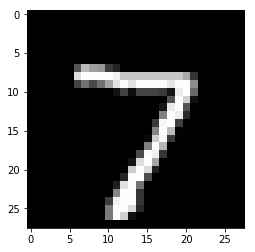

Model prediction: 7


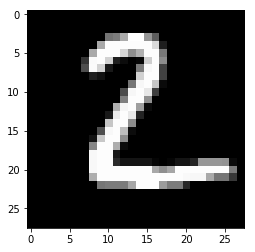

Model prediction: 2


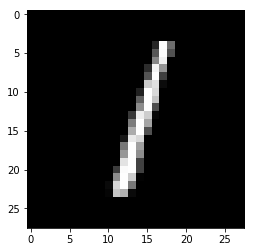

Model prediction: 1


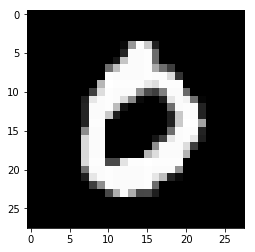

Model prediction: 0


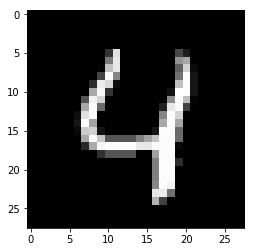

Model prediction: 4


In [12]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = neural_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))